In [1]:
import nbsetup
import seaborn as sns
import numpy as np
import ergodicpy as ep
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

In [28]:
DEFAULT = {
    'spikes': 6, # number of spikes
    'spread': 2, # how wide it goes
    'coherence': 1, # how self consistent spikes are
}

class Dataflake:
    
    def __init__(self, points=(30,360), lazy=False, parameters=DEFAULT):
        self.points = points # y, x
        self.index = range(points[0]*points[1])
        
        # maps of where points are
        self.point_map = np.ones(points)
        self.prob_map = np.zeros(points)
        # start with just bottom row
        self.prob_map[0] += 1/points[1]
        
        # total space
        self.y_space = np.linspace(0, 20, points[0])
        self.x_space = np.linspace(0, 360, points[1])
        
        # data to be pushed to plots
        self.ys = []
        self.xs = []
        
        # parameters
        self.parameters = parameters
        
        # create on creation
        if not lazy:
            self.run(int(points[0]*points[1]/12))
            self.plot()
        
    
    def place_point(self, point):
        x, y = point
        
        # place point on the visual map
        self.point_map[y][x] = 0
        
        # add data to scatter plots
        self.ys.append(y)
        self.xs.append(x)
        
        # adjust the probabilities
        
        # repeat pattern across spikes
        t = self.points[1]
        s = self.parameters['spikes']
        raw_ints = np.array([int(t*i/s) for i in range(1,s+1)])
        ints = (raw_ints+x)%t
        for i in ints:
            self.prob_map[y][i] += self.parameters['coherence']
        
        
        # increase probability above & below
        spread = self.parameters['spread']
        rows = self.points[0]
        if y < rows-1:
            # make the effect decrease new edges
            e = 1-y/rows
            self.prob_map[y+1][(x+spread)%t] += 1*e
            self.prob_map[y+1][(x-spread)%t] += 1*e
            self.prob_map[y+1][x] += 0.1*e
        
        if y > 1:
            e = 1-y/rows
            self.prob_map[y-1][(x+spread)%t] += 1*e
            self.prob_map[y-1][(x-spread)%t] += 1*e
        
        # push more points to the center
        gradient = np.flip(np.linspace(1,rows))        
        self.prob_map = np.array([row*gradient[i] for i, row in enumerate(self.prob_map)])
        
        # remove negatives
        self.prob_map = self.prob_map.clip(min=0)
        # remove points that exist already
        self.prob_map = self.prob_map*self.point_map
        # normalize
        self.prob_map = self.prob_map/self.prob_map.sum()
    
    def pick_point(self):
        indx = np.random.choice(self.index, p=self.prob_map.flatten())
        sh = self.points[1]
        x, y = int(indx%sh), int(indx/sh)
        return x, y
        
    def run(self, steps=1):
        for s in range(steps):
            self.place_point(self.pick_point())
        return self
    
    def dataframe(self):
        return pd.DataFrame(data={'angles':np.array(self.xs)*np.pi/180, 'radius': self.ys, 'position': np.arange(len(self.xs))})
    
    def plot(self):
        g = sns.FacetGrid(self.dataframe(), subplot_kws=dict(projection='polar'), height=5, sharex=False, sharey=False, despine=False)
        g.map_dataframe(sns.scatterplot, x='angles', y='radius', palette='crest_r', hue='position')
        g.set(xticks=[], yticks=[])
    
    def histogram(self, states=None):
        if states is None: states = self.points[1]
        digi = ep.digitize(self.xs, self.ys, ep.binint(0, self.points[1], states))[0]
        return np.array([len(row) for row in digi])


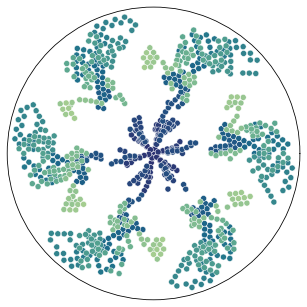

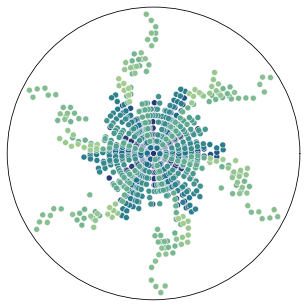

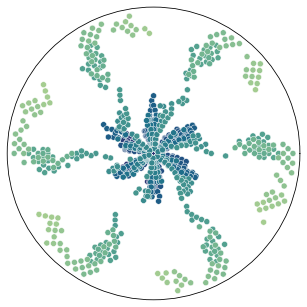

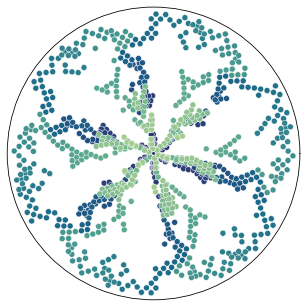

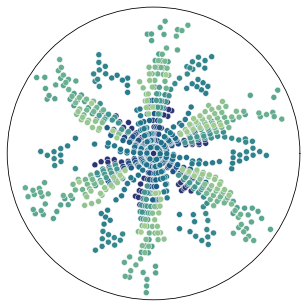

In [655]:
[Dataflake() for _ in range(5)]